In [4]:
#loading the libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import itertools

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/AIDatasets/Detecting-Depression-in-Tweets-master/sentiment_tweets3.csv'
filepath_dict = {'yelp': 'sentiment labelled sentences/yelp_labelled.txt' ,'amazon': 'sentiment labelled sentences /amazon_cells_labelled.txt','imdb':'sentiment labelled sentences/imdb_labelled.txt'}


In [7]:
df = []
df = pd.read_csv("/content/drive/MyDrive/AIDatasets/Detecting-Depression-in-Tweets-master/sentiment_tweets3.csv")

print(df.head())

   Unnamed: 0                                            message  label
0         106  just had a real good moment. i missssssssss hi...      0
1         217         is reading manga  http://plurk.com/p/mzp1e      0
2         220  @comeagainjen http://twitpic.com/2y2lx - http:...      0
3         288  @lapcat Need to send 'em to my accountant tomo...      0
4         540      ADD ME ON MYSPACE!!!  myspace.com/LookThunder      0


In [8]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0,10314):
    tweet = df['message'][i]
    tweet = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', tweet) # remove urls
    tweet = re.sub(r'#', '', tweet) # remove hashtag symbol
    tweet = re.sub(r'<([^>]*)>', ' ', tweet) # remove emojis
    tweet = re.sub('[^a-zA-Z]',' ', tweet) 
    tweet = tweet.lower()
    tweet = tweet.split()
#     ps = PorterStemmer()
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# df_yelp = df[df['source'] == 'yelp']

# sentences = df['message'].values
# y = df['label'].values
sentences = corpus
y = df['label'].values

sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,  
                                                test_size=0.25,  
                                                random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1                          

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [10]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):  #using GloVe
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/AIDatasets/glove.6B.50d.txt' ,tokenizer.word_index, embedding_dim)

In [12]:
# F1 score as a metrics in model training

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from keras.models import Sequential
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


#LSTM layer added [NEEDS WORK]

# model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# #model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m])
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/10
484/484 [==============================] - 15s 29ms/step - loss: 0.2102 - accuracy: 0.9463 - f1_m: 0.7548 - val_loss: 0.1404 - val_accuracy: 0.9957 - val_f1_m: 0.9489
Epoch 2/10
484/484 [==============================] - 14s 29ms/step - loss: 0.1156 - accuracy: 0.9972 - f1_m: 0.9745 - val_loss: 0.1054 - val_accuracy: 0.9969 - val_f1_m: 0.9575
Epoch 3/10
484/484 [==============================] - 14s 29ms/step - loss: 0.0527 - accuracy: 0.9988 - f1_m: 0.9863 - val_loss: 0.0251 - val_accuracy: 0.9965 - val_f1_m: 0.9513
Epoch 4/10
484/484 [==============================] - 14s 29ms/step - loss: 0.0042 - accuracy: 0.9988 - f1_m: 0.9809 - val_loss: 0.0224 - val_accuracy: 0.9969 - val_f1_m: 0.9575
Epoch 5/10
484/484 [==============================] - 14s 28ms/step - loss: 0.0030 - accuracy: 0.9994 - f1_m: 0.9738 - val_loss: 0.0250 - val_accuracy: 0.9969 - val_f1_m: 0.9575
Epoch 6/10
484/484 [==============================] - 14s 29ms/step - loss: 0.0030 - accuracy: 0.9991 - f1_m: 

In [ ]:
# loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

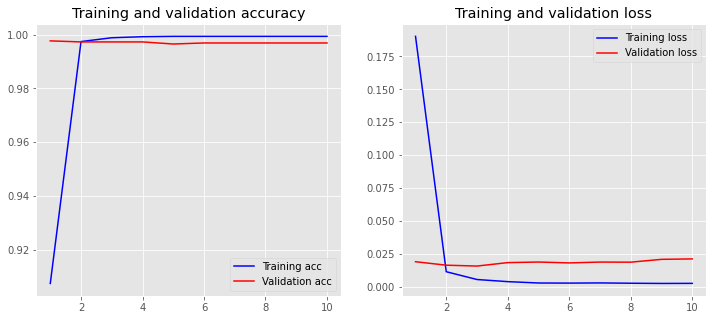

In [ ]:
plot_history(history)

# -------------------------------------------------------------------------

In [ ]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_nb = confusion_matrix(y_test,y_pred)